In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from scipy import integrate

import sys
sys.path.append('../')
from models import toynet, ema
from evolutions import *
from utils import loss_AM, solve_ode_rk, solve_ode, stack_imgs, ANet

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

In [3]:
from utils import get_dataset_MNIST as get_dataset
from config_mnist import get_configs
config = get_configs()

In [4]:
config.model.savepath = 'am_mnist_vpsde'

## Load model

In [5]:
device = torch.device('cuda')
use_ema = False
train_loader, val_loader = get_dataset(config)

net = nn.DataParallel(ANet(config))
net.to(device)

state = torch.load('../' + config.model.savepath)
net.load_state_dict(state['model'], strict=True)
if use_ema:
    ema_ = ema.ExponentialMovingAverage(net.parameters(), decay=0.9999)
    ema_.load_state_dict(state['ema'])
    ema_.copy_to(net.parameters())
net.eval()
s = get_s(net, config.model.s)

In [6]:
x_1 = torch.randn(64, config.data.num_channels, config.data.image_size, config.data.image_size).to(device)
img = solve_ode_rk(device, s, x_1)

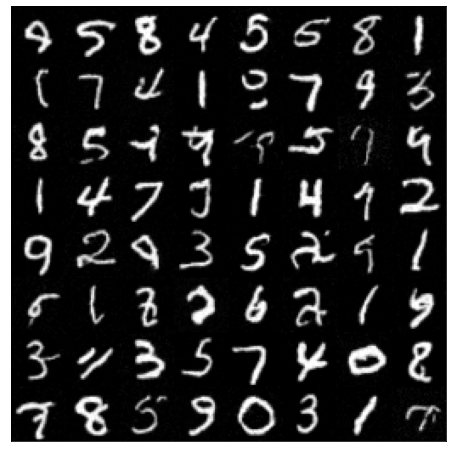

In [7]:
figsize(10,8)
big_img = stack_imgs(img)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [49]:
x_1 = torch.randn(64, config.data.num_channels, config.data.image_size, config.data.image_size).to(device)
shape = x_1.shape
x_1 = x_1.detach().cpu().numpy().flatten()

def ode_func(t, x):
    sample = torch.from_numpy(x).reshape(shape).to(device).type(torch.float32)
    vec_t = torch.ones(sample.shape[0], device=sample.device) * t
    sample.requires_grad = True
    dx = torch.autograd.grad(s(vec_t, sample).sum(), sample)[0].detach()
    sample.detach()
    dx = dx.detach().cpu().numpy().flatten()
    return dx

In [50]:
solution = integrate.solve_ivp(ode_func, (1.0, 0.0), x_1, rtol=1e-7, atol=1e-7, method='RK45')

In [51]:
solution['y'].shape

(65536, 31)

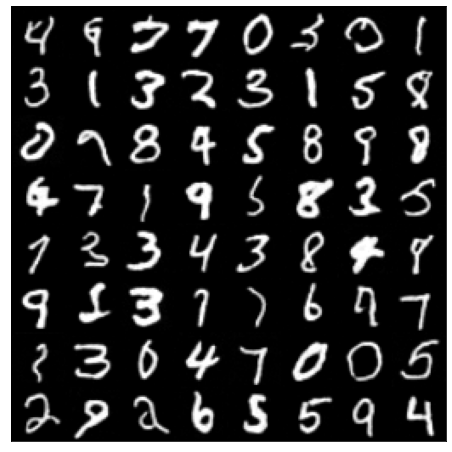

In [52]:
figsize(10,8)
big_img = stack_imgs(torch.from_numpy(solution['y'][:,-1].reshape(shape)))
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

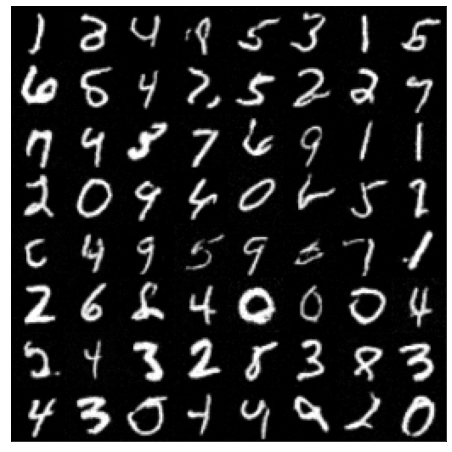

In [36]:
figsize(10,8)
big_img = stack_imgs(torch.from_numpy(solution['y'][:,-1].reshape(shape)))
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

## Visualize

In [26]:
x_1 = torch.randn(64, config.data.num_channels, config.data.image_size, config.data.image_size).to(device)
frame_ids = list(range(1000))[::5]
frame_ids.append(999)
x_0, x_inter, t_inter = solve_ode(device, s, x_1, frame_ids)

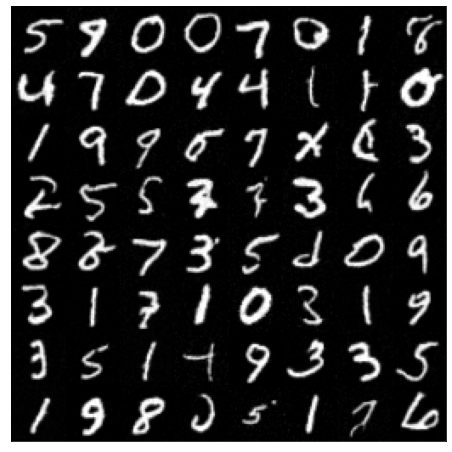

In [31]:
figsize(10,8)
big_img = stack_imgs(x_0.cpu())
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [41]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
    big_img = stack_imgs(x_t.cpu())
    plt.imshow(big_img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('gifs/mnist_vp/%.3d.jpeg' % i, bbox_inches='tight', dpi=60)
    plt.clf()

<Figure size 720x576 with 0 Axes>

In [42]:
!convert -delay 10 -loop 0 ./gifs/mnist_vp/*.jpeg ./gifs/mnist_vp.gif